# MLBD / Lab 2 / Feature extraction

## Report submission

This laboratory will be graded, so you have to submit a report. You can work in groups of up to 2 persons and submit a report for each group with the following constraints :

- the report must be **AT MOST** 4 pages
- it should contain answer to the questions asked in this notebook
- it should contain an explanation of the feature you implemented with an overview of how it works (e.g., show some examples) and why you think it is useful
- include your results (either as classification report or confusion matrix) for the kNN classifier
- include the parameters you chose for the knn (value of k) and why you chose it.
- include an analysis of your results

Also include a copy of your scripts (.ipynb or .py) that you used WITHOUT the data. The grading will **ONLY be based on the report** and if we have to look at your scripts to understand what you did, it's a bad sign.


## Introduction

In this laboratory, we will work with images of plant leaves. The goal is to identify the plant species from the image.

To do so, we will use some concepts that have been presented in the theoretical part of the course :
- Feature extraction to turn an image into a vector of features
    - This will involve using PCA (Principal Component Analysis)

### Dataset information

We will use the ImageClef 2012 Plant classification dataset. To simplify things, we have already extracted a small part of the dataset that we will be working on (in the "data/preprocessed" directory).

The notebook additionals/lab2_preprocess contains the preprocessing code (background substraction, image size normalization) that was used to create the subset of the data used in this laboratory.

Note that **it is not required** to download the full dataset. Neither do you need to run the lab2_preprocess notebook as this has already been done for you. But you can have a look if you are interested.

The full dataset can be downloaded from : 

http://www.imageclef.org/2012/plant

The direct link is :

http://otmedia.lirmm.fr/LifeCLEF/ImageCLEF2011-2012-2013/ImageCLEF2012PlantIdentificationTaskFinalPackage.zip

It is interesting to download this dataset and have a look at the files in *data/SomeStatAndHtmlViewBySpecies/TrainAndTestViewsBySpecies*, which gives a nice overview of the type of plants in the dataset.

This dataset was originally used in a challenge. In the *OralPresentationsAndPosters* directory, there are some presentations from the teams that participated in the challenge with information about the type of preprocessing, features and classifiers used. This is very interesting if you are looking for inspiration about what you could implement.


### Note about OpenCV

We will use the OpenCV image processing library to extract some features from the images. If it is not already done, you can install it using anaconda with the following command :

    $ conda install opencv
    
You should then be able to import the OpenCV python module, called **cv2**.

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import numpy.ma as ma
import numpy.linalg as la
import skimage
import skimage.io
from matplotlib import pyplot as pl
import matplotlib.cm as cm
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)

## Dataset overview
Before doing this step you must copy the compressed file "ImageCLEF_DB.zip" data in the colab space:
### left panel -> Files ->UPLOAD
Or uncomment the following cell if you copied the data to your drive account



In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

#!ls 'drive/My Drive/MSE/semester_2/mldb/labo_2'
#!cp 'drive/My Drive/MSE/semester_2/mldb/labo_2/imageCLEF_DB.zip' .

In [3]:
if os.path.exists('imageCLEF_DB'):
    print('Data are already in folder')
else:
    if os.path.exists('imageCLEF_DB.zip'):
        !unzip imageCLEF_DB.zip
    else:
        print('You must upload the data first!')

Data are already in folder


In [4]:
DIR = 'imageCLEF_DB/data/preprocessed/'
meta = pd.io.pickle.read_pickle(os.path.join(DIR, 'meta.pkl'))

def load_img(name):
    """Loads the given image by name and returns a masked array"""
    img = skimage.io.imread(os.path.join(DIR, 'imgs', name + ".png"))
    img = skimage.img_as_float(img)
    img = ma.masked_where(img == 0, img)
    # same mask for all 3 axes
    mask = np.all(img == 0, axis=2)
    img = ma.array(img)
    for i in range(img.shape[2]):
        img.mask[:,:,i] = mask

    return img

The meta dataframe contains information for each image :

- *basename* is the filename (without extension) of the image.
- *content* gives information about the image content. To simplify the problem, we selected only images of plant leaves on uniform backgrounds, but the original dataset has more variety. 
- *classid* is the class. We selected 9 classes from the original dataset.
- *photo_type* is the type of photo. To simplify, we used only scan and pseudoscan (=uniform background) images

In [5]:
meta.iloc[:5]

,basename,content,classid,photo_type
49,10047,leaf,arbutus unedo,pseudoscan
70,10073,leaf,nerium oleander,pseudoscan
85,10092,leaf,nerium oleander,scan
117,10129,leaf,acer campestre,scan
123,10135,leaf,quercus pubescens,pseudoscan


You can use the *load_img* function to load an image.

** Masked arrays: ** Notice that we are using [numpy *masked* arrays](http://docs.scipy.org/doc/numpy/reference/maskedarray.html), which are a special type of numpy array that have a mask. The mask is a boolean array that indicates if an entry is valid (mask[i,j] == False) or invalid (mask[i,j] == True). For our images, the background pixels are all masked. You can access the mask by using the .mask attribute of the array. Below, we use img.filled(1) to get a copy of the array with masked values replaced by 1. 

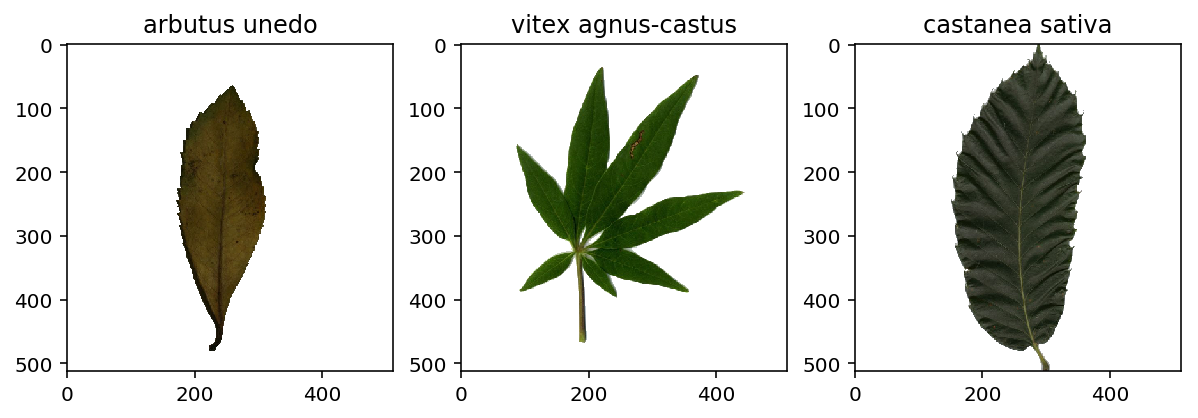

In [6]:
# Show 3 example images
#examples = [2, 13, 7, 3, 8, 19,26,30,50]
examples = [26,30,50]

pl.figure(figsize=(10, 3))
for i, idx in enumerate(examples): 
    pl.subplot(1, 3, i + 1)
    img = load_img(meta.iloc[idx]['basename'])
    pl.title(meta.iloc[idx]['classid'])
    pl.imshow(img.filled(1))

In [7]:
# The classes we will work with
print(np.unique(meta['classid']))

['acer campestre' 'ailanthus altissima' 'alnus glutinosa' 'arbutus unedo'
 'castanea sativa' 'liquidambar styraciflua' 'nerium oleander'
 'quercus pubescens' 'vitex agnus-castus']


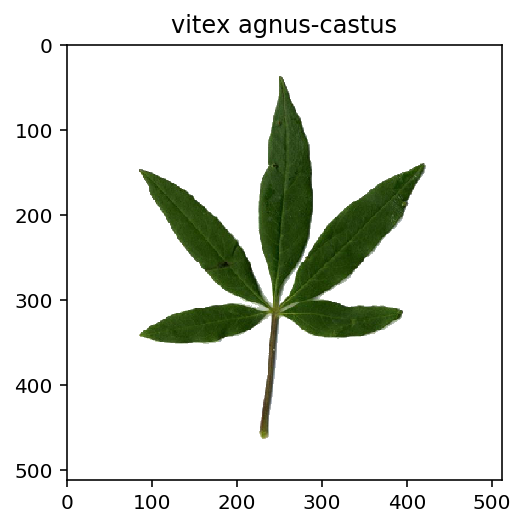

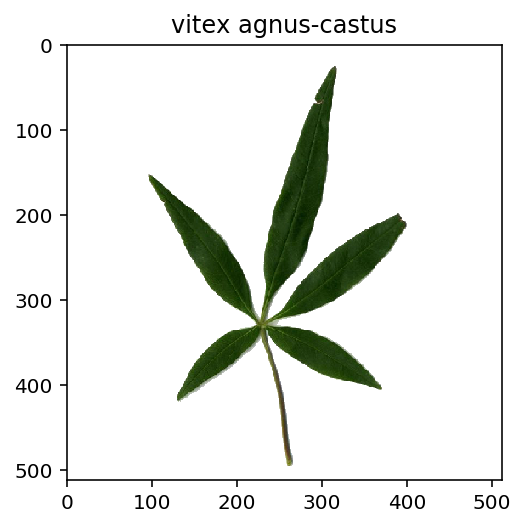

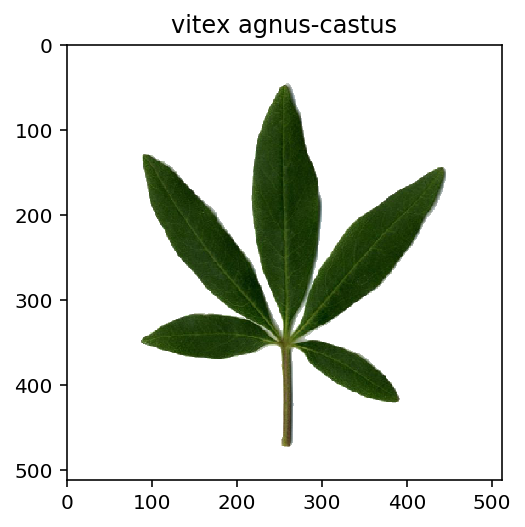

In [8]:
# You can plot some examples images for a given species
import random
examples = np.flatnonzero(meta['classid'] == 'vitex agnus-castus')

for idx in random.sample(list(examples), 3):
    pl.figure()
    img = load_img(meta.iloc[idx]['basename'])
    pl.title(meta.iloc[idx]['classid'])
    pl.imshow(img.filled(1))

## Feature extraction

So, we have images of leaves and we want to train a classifier to automatically determine the species of a leaf.

What should we use as input vectors for our classifier ?

The bruteforce approach could be to use a flattened version of all the image pixels (you concatenate all the rows in the image). Since we have images that have a size of 512x512, this would result in 262144 (512*512) dimensional input vectors.

For most classifiers, this is way too much dimensions. Also, this would mean that if you translate your image by one pixel, the input vector will change dramatically. Later in the course, we will see that deep learning classifiers are able to use data in such an unprocessed form, but for now, we have to extract features.

The better approach is to extract features to represent each image. If we ask you to manually classify those images, what will you look at ? Color ? The general shape of the leaf (i.e. elongated, round) ? The texture of the leaf ?

We will try to extract features that allow our classifier to use the same kind of hints that a human would use. We will start with two features : *eccentricity* and *curvature*. You will then have to propose and implement a new feature and see how the new information impacts classification performance.

First, we define some utility functions :

In [9]:
def get_plant_points(img):
    """
    Given the image of a plant, returns a Nx2 array containing the (x, y) coordinate
    of all non-masked points
    """
    # this returns (y, x) tuple
    points = np.transpose(np.nonzero(~img.mask)[:2])
    # makes that an (x, y) tuple
    points = np.roll(points, 1, axis=1)
    return points

def extract_contour(img):
    """
    Wrapper around OpenCV's contour extraction methods. This returns only the longest
    contour
    """
    _, contours, hierarchy = cv2.findContours(
        skimage.img_as_ubyte(~img.mask[:,:,0]),
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_NONE
    )

    # only take longest contour into account
    longest_contour = np.argmax([len(c) for c in contours])
    cnt = contours[longest_contour]
    cnt = np.squeeze(cnt)
    return cnt

### Eccentricity

Eccentricity gives us information about how the distribution of the leaf points deviates from a perfect circle.

The *get_plant_points* method above gives us the coordinate $(x, y)$ of all foreground (non-masked) points in the image. If we perform PCA on those points, we get two orthogonal (uncorrelated) principal axis (components) which are :

- The first axis is the axis with maximum variance
- The second axis is orthogonal to the first

In addition, each axis (which are the eigenvectors of the covariance matrix of our data) has an associated eigenvalue. The eigenvalue informs us about the relative importance of each axis.

We compute the eccentricity as the ratio of the eigenvalues of the two axis. If our points are distributed in a perfect circle, both axes will have equal importance and the ratio will be 1.

In [10]:
from sklearn.decomposition import PCA

def eccentricity(img, plot=False):
    """Compute eccentricity : the ratio of the eigenvalues of principal components"""
    points = get_plant_points(img)
    pca = PCA(n_components=2).fit(points)
    centroid = pca.mean_
    eccentricity = pca.explained_variance_[0] / pca.explained_variance_[1]

    if plot:
        pl.title('eccentricity : %f' % eccentricity)
        pl.imshow(img)

        # direction of the two principal components
        d1 = pca.components_[0,:]
        d2 = pca.components_[1,:]

        scale = 100
        p1 = centroid + scale * d1 * pca.explained_variance_ratio_[0]
        pl.plot([centroid[0], p1[0]], [centroid[1], p1[1]], c='r')

        p2 = centroid + scale * d2 * pca.explained_variance_ratio_[1]
        pl.plot([centroid[0], p2[0]], [centroid[1], p2[1]], c='y')

        pl.xlim((0, img.shape[1]))
        pl.ylim((img.shape[0], 0))

    return eccentricity

First, let's play with circles and ellipses

4.005797732692261

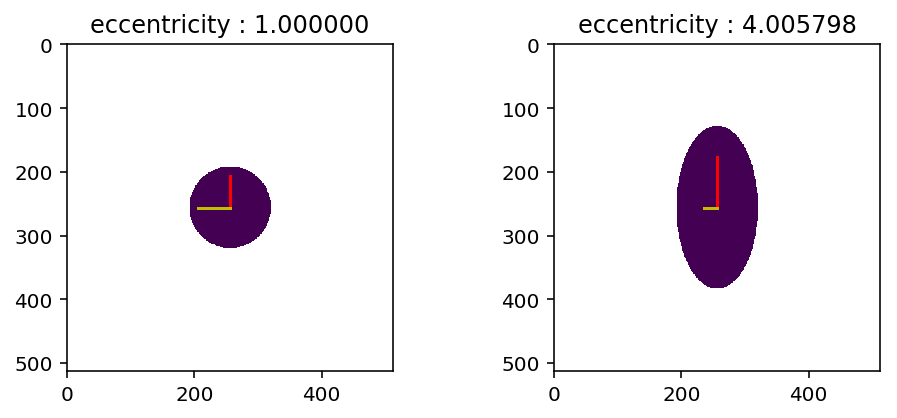

In [11]:
import skimage.draw

def get_ellipse_image(yradius, xradius):
    img = ma.masked_all((512, 512), dtype=np.float)
    rr, cc = skimage.draw.ellipse(256, 256, r_radius=yradius, c_radius=xradius, shape=(512, 512))
    img[rr, cc] = 1
    return img

pl.figure(figsize=(8, 3))
pl.subplot(121)
# This is a circle
eccentricity(get_ellipse_image(64, 64), plot=True)

pl.subplot(122)
# An ellipse
eccentricity(get_ellipse_image(128, 64), plot=True)

Ok so now we can apply eccentricity on our images

basename                10092
content                  leaf
classid       nerium oleander
photo_type               scan
Name: 85, dtype: object
basename                    10277
content                      leaf
classid       ailanthus altissima
photo_type             pseudoscan
Name: 250, dtype: object


basename                  10205
content                    leaf
classid       quercus pubescens
photo_type           pseudoscan
Name: 188, dtype: object


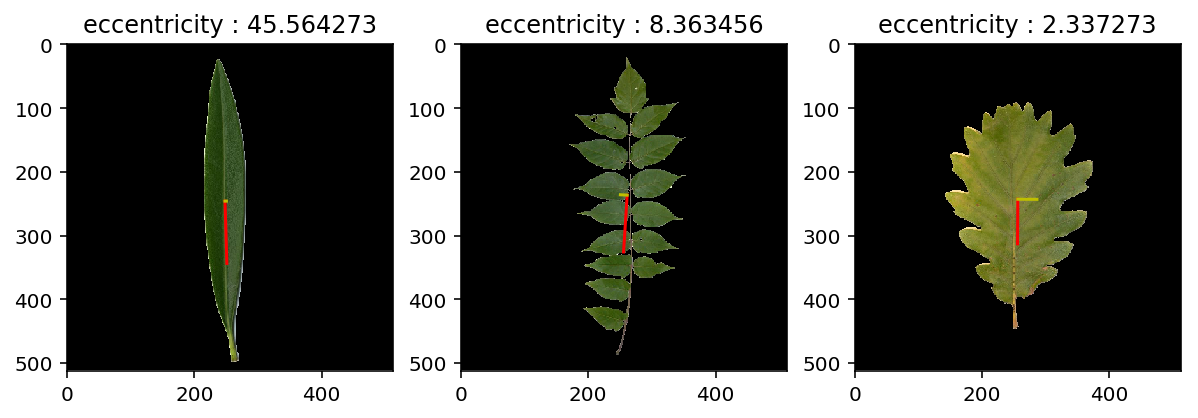

In [12]:
examples = [2, 13, 7]
#examples = [2, 13, 7, 3, 8, 19,26,30,50]
pl.figure(figsize=(10, 3))
for i, idx in enumerate(examples):
    pl.subplot(1, 3, i + 1)
    print(meta.iloc[idx])
    img = load_img(meta.iloc[idx]['basename'])
    eccentricity(img, plot=True)

### Curvature

We will compute the [curvature](http://en.wikipedia.org/wiki/Curvature#Curvature_of_plane_curves) of the contour of the leaf. This will help describe the "pointiness" of the contour.

The function does the following steps :

- Extract the leaf contour (using OpenCV's contour extraction functions).
- Compute the curvature for each point on the contour.
- Compute an histogram of all the curvatures of contour points.

The final feature vector will be the histogram. The number of bins in the histogram define the dimensionality of the feature vector.

There are three parameters that are important when computing our curvature feature :

- *step* : To compute curvature for a given point, we need a previous and next point and then use those 3 points to construct a circumcircle, the (inverse of the) radius of which is the curvature. The step determine how far away we pick our previous and next point.

<img width="200px" src="http://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Osculating_circle.svg/460px-Osculating_circle.svg.png" />

- *nbins* and *vmax* : When computing our histogram of curvatures, we have to decide the number of bins in the histogram. We also have to decide the range of the bins, which will be in [0, vmax] . 

In [13]:
from matplotlib import gridspec

def circumcircle_radius(p1, p2, p3):
    """
    Given 3 points of a triangle, computes the radius of the circumcircle
    http://www.mathopenref.com/trianglecircumcircle.html

    This function can return np.inf if the triangle has an area of zero
    """
    a = la.norm(p2 - p1)
    b = la.norm(p3 - p2)
    c = la.norm(p1 - p3)
    #print a, b, c

    # Check for degenerate case (triangle has an area of zero)
    denom = np.fabs((a+b+c)*(b+c-a)*(c+a-b)*(a+b-c))
    if abs(denom) < 1e-5:
        return np.inf
    else:
        r = (a * b * c)/np.sqrt(denom)
        return r

def curvature_from_cnt(line, step=10):
    """
    Curvature computation for a line given as a Nx2 array
    We assumes the line is closed (ie the last and first point are contiguous)

    Each set of 3 consecutive (see step) points on the line forms a triangle
    and the radius of the circumcircle of this triangle is the radius of
    the curve for that set. The curvature is 1/r where r is this radius.

    Taking immediatly consecutive points doesn't work well, so `step` specify
    how points triplets are formed : (i-step, i, i+step)
    """
    # Append line end at beginning and beginning at end to simulate closed
    # line
    l = np.r_[line[-1].reshape(-1, 2),
              np.array(line),
              line[0].reshape(-1, 2)]
    curv = []
    linelen = line.shape[0]
    for i in range(linelen):
        # indices in l are shifted by -1
        #r = circumcircle_radius(l[i], l[i+1], l[i+2])
        r = circumcircle_radius(line[(i-step)%linelen],
                                line[i],
                                line[(i+step)%linelen])
        if np.isinf(r):
            # Flat => curvature = 0
            curv.append(0)
        else:
            curv.append(1.0 / r)
    return np.array(curv)

def curvature(img, step=10, plot=False, gs=None):
    cnt = extract_contour(img)

    cvt = curvature_from_cnt(cnt, step=step)

    if plot:
        if gs is None:
            gs = gridspec.GridSpec(1, 2)
        vimg = skimage.img_as_ubyte(img)
        cv2.drawContours(vimg, [cnt], 0, (0,255,0), 3)

        pl.subplot(gs[0])
        pl.title(meta.iloc[idx]['classid'])
        #pl.title('contour')
        pl.imshow(vimg)
        pl.axis('off')

        pl.subplot(gs[1])
        pl.title('curvature')
        pl.imshow(img)
        pl.scatter(cnt[:,0], cnt[:,1], c=cvt, linewidths=0, s=5)
        pl.xlim((0, img.shape[1]))
        pl.ylim((img.shape[0], 0))
        pl.axis('off')

    return cvt

## Q: Implement the curvature_hist function

This function should take an image as input and return a vector of dimension $n$ representing the histogram of contour curvatures for the given image with $n$ bins. The signature should be :

    def curvature_hist(img, step=10, plot=False):
        # implement here


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


[0.88278 0.07365 0.00311 0.00311 0.00207 0.00415 0.00519 0.00622 0.0083
 0.01037]


[0.39352 0.24817 0.10178 0.04148 0.03032 0.01673 0.01359 0.01778 0.02161
 0.04287]


[0.25075 0.22147 0.11787 0.07057 0.06156 0.05105 0.06682 0.06532 0.04279
 0.02778]


[0.50452 0.21318 0.10853 0.05168 0.04457 0.02584 0.01421 0.00969 0.00904
 0.00904]


[0.3963  0.25627 0.13078 0.04756 0.03963 0.03567 0.02114 0.03303 0.01849
 0.01321]


[0.49912 0.26018 0.14159 0.05841 0.01593 0.00177 0.      0.00354 0.00177
 0.01062]


[0.48    0.22919 0.11892 0.09081 0.03892 0.01405 0.00757 0.00757 0.00216
 0.00649]


[0.72678 0.13707 0.02004 0.0123  0.0082  0.00729 0.01002 0.01138 0.01913
 0.02732]


[0.28635 0.2059  0.11882 0.06642 0.04502 0.04576 0.0428  0.04797 0.03911
 0.0369 ]


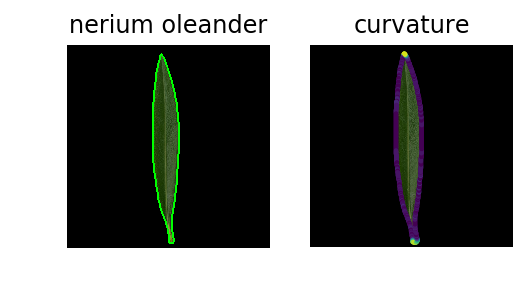

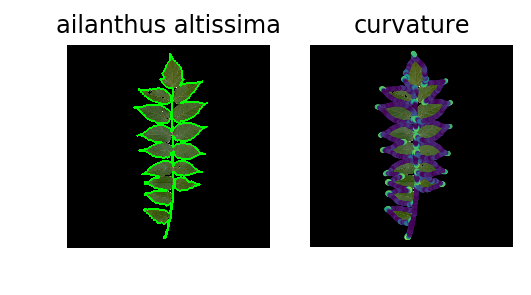

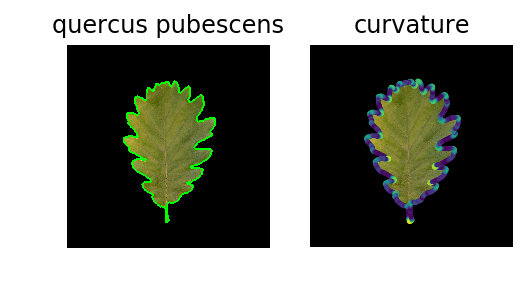

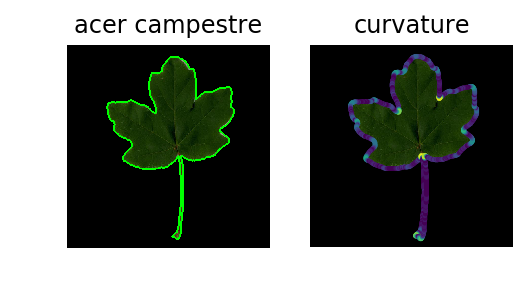

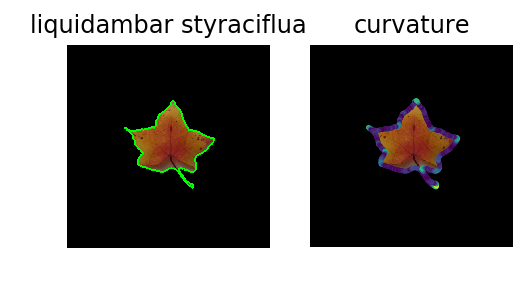

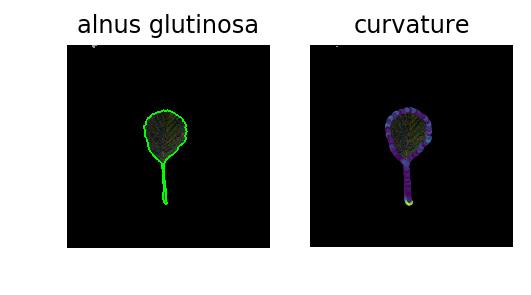

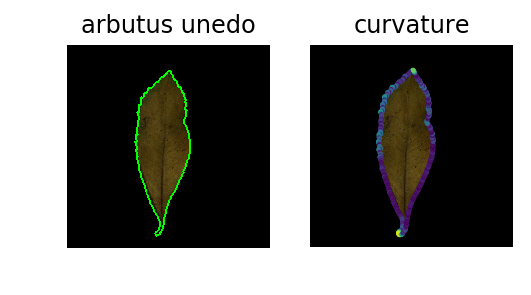

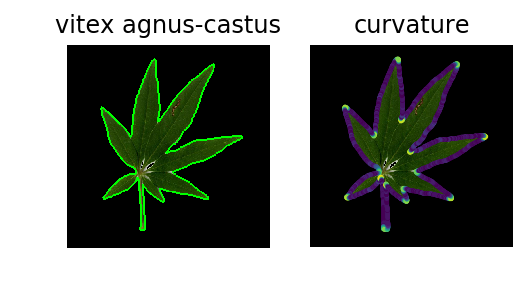

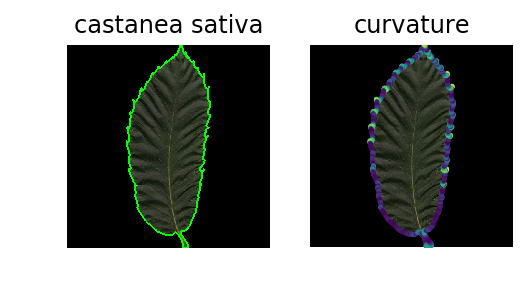

In [14]:
#
# Your curvature_hist code here
#
def curvature_hist(img, step=2, plot=False):
    n_bins = 10
    bin_width = 0.02
    x_start = 0
    x_end = 0.18

    curvatures = curvature(img, step=step, plot=True)
    bins = np.linspace(x_start, x_end, n_bins+1)
    res, _ = np.histogram(curvatures, bins=bins, range=(x_start, x_end))
    res = res / float(len(curvatures))

    if plot:
        pl.title(meta.iloc[idx]['classid'])
        #pl.title('Curvatures\' Histogram')
        pl.bar(bins[1:], res, width=bin_width)

    return res

examples = [2, 13, 7, 3, 8, 19,26,30,50]
#examples = [19, 44, 3, 6]
for i, idx in enumerate(examples):
    pl.figure(figsize=(4, 4))
    img = load_img(meta.iloc[idx]['basename'])
    c = curvature_hist(img, step=10, plot=False)
    print(c)

In [15]:
m1 = meta['classid'] == 'alnus glutinosa'
m2 = meta['classid'] == 'acer campestre'
print(np.flatnonzero(m1))
print(np.flatnonzero(m2))

[ 19  44  64 170 178 194 208 214 232 250 286 303 306 313 328 338 421 423
 433 444 478 484 507 512 516 537 540 574]
[  3   6  11  14  17  24  43  63  78  80  91  95 111 125 126 129 130 146
 182 200 213 246 248 264 273 280 281 282 289 290 292 295 307 318 319 325
 339 355 360 375 384 411 420 427 430 434 436 453 454 458 460 463 464 465
 508 510 513 527 530 531 541 552 555 557 558 562 566]


### Implement your own features

http://www.math.uci.edu/icamp/summer/research_11/park/shape_descriptors_survey.pdf

## Q: Implement a new feature</p>

Implement a new feature extractor that you think could be useful for this classification task. Explain why your feature extractor is useful. You can look at the presentations accompanying the original dataset for inspiration. You can also start building on the convex hull example below.

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


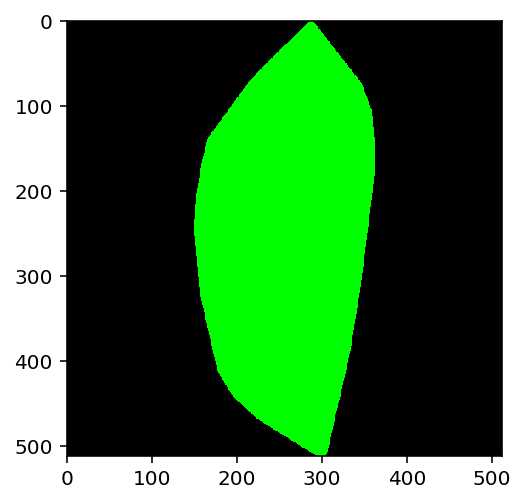

In [16]:
# As an example, OpenCV allows you to compute the convex hull of a shape. An idea of feature might be
# to compute the ratio of area covered by valid pixels versus the convex hull area
cnt = extract_contour(img)
hull = cv2.convexHull(cnt)
vimg = skimage.img_as_ubyte(img)
cv2.drawContours(vimg, [hull], 0, (0,255,0), -1)
pl.imshow(vimg)

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


1.4362136931969334

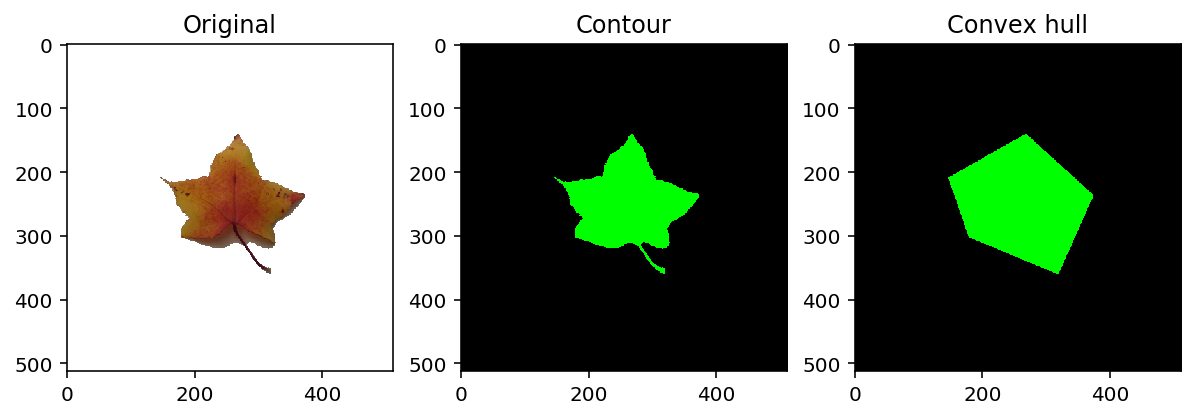

In [17]:
idx = 8
img = load_img(meta.iloc[idx]['basename'])

def hull_concave_ratio(img, plot = False):
    p = get_plant_points(img)
    cnt = extract_contour(img)
    hull = cv2.convexHull(cnt)

    if plot:
        pl.figure(figsize=(10, 3))
        vimg = skimage.img_as_ubyte(img)
        contourImg = vimg.copy()
        cv2.drawContours(vimg, [hull], 0, (0,255,0), -1)
        cv2.drawContours(contourImg, [cnt], 0, (0,255,0), -1)
        pl.subplot(1, 3, 1)
        pl.title('Original')

        pl.imshow(img.filled(1))
        pl.subplot(1, 3, 2)
        pl.title('Contour')

        pl.imshow(contourImg)
        pl.subplot(1, 3, 3)
        pl.title('Convex hull')

        pl.imshow(vimg)

    return cv2.contourArea(hull)/cv2.contourArea(cnt)

hull_concave_ratio(img, True)

<p style="background-color:#660066; color:#fff;padding:5px; font-weight:bold">Q: Use the features to train and evaluate a k-NN classifier</p>

This involves :

- Compute the feature vector of each image (by concatenating individual features of the image).
- Build a $n$ x $m$ data matrix $X$ with the feature vectors of all the images, where $n$ is the number of images and $m$ the number of features.
- Build an integer vector of length $n$, $y$, containing the target class for each image. *sklearn.preprocessing.LabelEncoder* is useful for converting text labels into integers.
- Split your dataset into training and test : X_train, X_test, y_train, y_test. *sklearn.cross_validation* has useful utility functions for that.
- Normalizing your data. *sklearn.preprocessing.MinMaxScaler* might be useful (or other similar scaler classes)
- Build a classifier with *sklearn.neighbors.KNeighborsClassifier* on your training dataset and evaluate on your test dataset.
    - this the *y_pred = knn.predict(X_test)* cell

After you have evaluated your model **write a short analysis of your results**.


In [18]:
#
# Your KNN code here
#

In [19]:
from sklearn import preprocessing

def label_encoder(meta):
    le = preprocessing.LabelEncoder()
    classids = {}

    for i in range(0, len(meta)-1):
        elem = meta.iloc[i]
        if not elem['classid'] in classids :
            classids[elem['classid']] = True

    le.fit([*classids.keys()])
    return le

labelEncoder = label_encoder(meta)

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


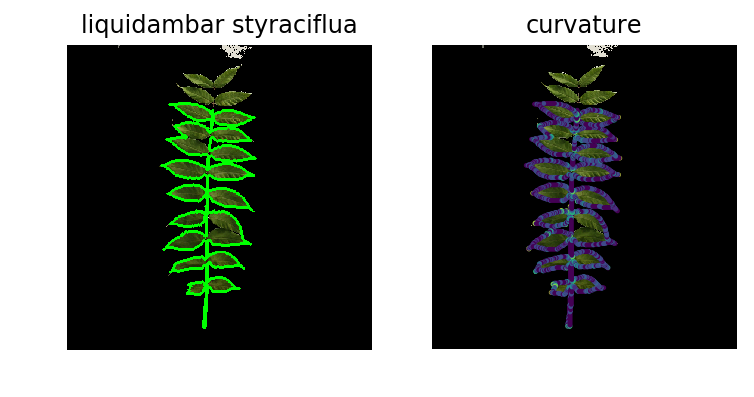

In [20]:
from sklearn import model_selection
from sklearn import neighbors

rows_nb = 12

def extract_dataset(meta, labelEncoder):
    features = np.zeros((len(meta), rows_nb))
    classes = np.zeros((len(meta), 1))

    for i in range(0, len(meta)-1):
        elem = meta.iloc[i]
        features[i,:] = extract_features(elem)
        classes[i,:] = labelEncoder.transform([elem['classid']])

    return normalize( features ), classes

def extract_features(meta_elem):
    img = load_img(meta_elem['basename'])
    res = np.zeros((1,rows_nb))
    res[0,0] = eccentricity(img)
    res[0,1] = hull_concave_ratio(img)
    res[0,2:12] = curvature_hist(img).reshape((1,10))
    return res

def normalize(features):
    nbi, nbf = features.shape
    res = np.zeros((nbi,nbf))
    for i in range(0,nbf-1):
        scaler = preprocessing.MinMaxScaler()
        scaler.fit(features[:,i].reshape(-1, 1))
        res[:,i] = scaler.transform(features[:,i].reshape(1, -1))
    return res

features, classes = extract_dataset(meta, labelEncoder)

In [21]:
def plot_confusion_matrix(confmat, labels_names, ax=None, cmap=None):
    """Utility function to plot a confusion matrix"""
    if ax is None:
        ax = pl.subplot(111)
    cmim = ax.matshow(confmat, interpolation='nearest', cmap=cmap)

    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.annotate(str(confmat[i, j]), xy=(j, i),
                        horizontalalignment='center',
                        verticalalignment='center',
                        fontsize=8)
    ax.set_xticks(np.arange(confmat.shape[0]))
    ax.set_xticklabels([labels_names[l] for l in range(confmat.shape[0])], rotation='vertical')
    ax.set_yticks(np.arange(confmat.shape[1]))
    _ = ax.set_yticklabels([labels_names[l] for l in range(confmat.shape[1])])
    ax.set_xlabel('predicted label')
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('true label')
    pl.colorbar(cmim, shrink=0.7, orientation='horizontal', pad=0.01)

In [22]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(normalize(features), classes, test_size=0.32)

In [23]:
from sklearn.metrics import accuracy_score
accuracies = []
# Try to find best K
for k in range (1, 100):
            knn = neighbors.KNeighborsClassifier(n_neighbors = k)
            knn.fit(X_train, y_train[:,0])
            y_pred = knn.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append((accuracy, k))

accuracies.sort(reverse=True)
print("Top 6 tuples: {}\n{}\n{}\n{}\n{}\n{}".format(accuracies[0],accuracies[1],accuracies[2],accuracies[3],accuracies[4],accuracies[5]))

if accuracies[0][1] == 1:
    accuracies[0] = accuracies[1]

Top 6 tuples: (0.7379679144385026, 5)
(0.732620320855615, 6)
(0.7272727272727273, 4)
(0.7272727272727273, 3)
(0.7219251336898396, 8)
(0.7219251336898396, 1)


In [24]:
knn = neighbors.KNeighborsClassifier(n_neighbors = accuracies[0][1])
knn.fit(X_train, y_train[:,0])

y_pred = knn.predict(X_test)
# performance evaluation.                        - for lencoder see sklearn.preprocessing.LabelEncoder
import sklearn.metrics as skmetrics
from sklearn.metrics import confusion_matrix

lencoder = labelEncoder # confused about why this variable changed its name now...
report = skmetrics.classification_report(y_test, y_pred,
                                         labels=np.arange(len(lencoder.classes_)),
                                         target_names=lencoder.classes_)
confmat = confusion_matrix(y_test, y_pred)

                         precision    recall  f1-score   support

         acer campestre       0.67      0.62      0.64        26
    ailanthus altissima       0.90      0.90      0.90        20
        alnus glutinosa       0.43      0.30      0.35        10
          arbutus unedo       0.58      0.54      0.56        26
        castanea sativa       0.58      0.69      0.63        16
liquidambar styraciflua       0.50      0.20      0.29         5
        nerium oleander       1.00      1.00      1.00        33
      quercus pubescens       0.55      0.72      0.62        25
     vitex agnus-castus       0.96      0.92      0.94        26

              micro avg       0.74      0.74      0.74       187
              macro avg       0.68      0.65      0.66       187
           weighted avg       0.74      0.74      0.73       187



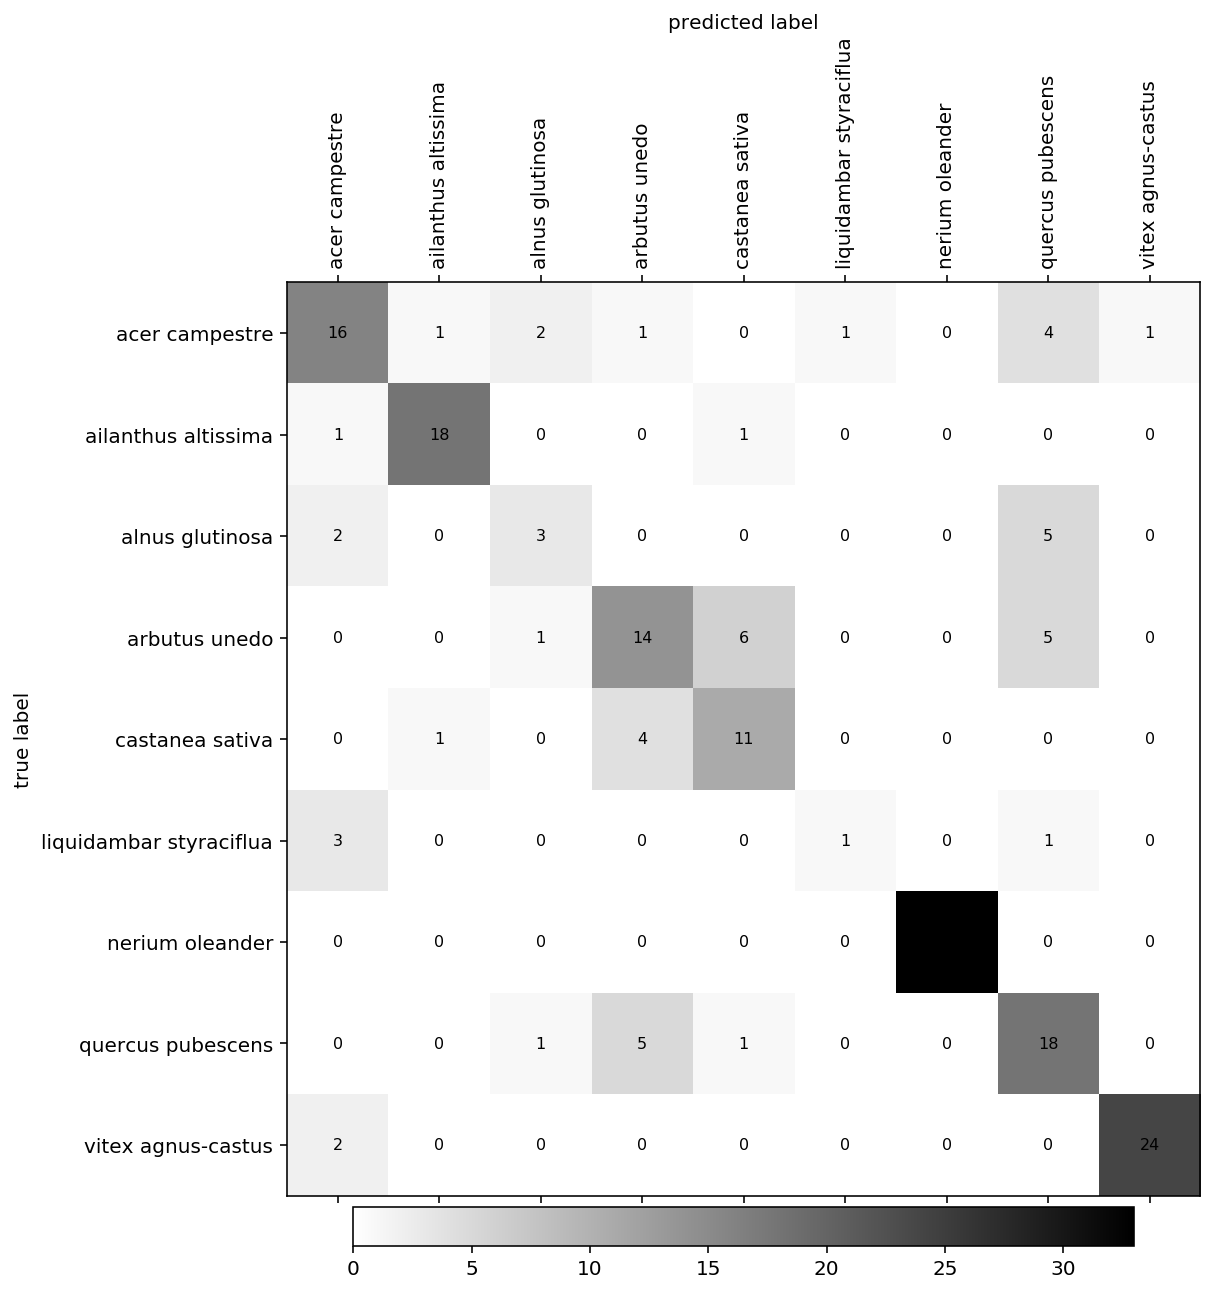

In [25]:
pl.figure(figsize=(10, 10))
plot_confusion_matrix(confmat, lencoder.classes_, cmap=cm.gray_r)

print(report)

In [26]:
# MLP using scikit
from sklearn.neural_network import MLPClassifier

accuracies = []

# Try to find best number of neurons
for i in range (1, 10):
    for j in range (1,10):
            clf = MLPClassifier(activation='tanh', solver='lbfgs', alpha=1e-4, hidden_layer_sizes=(i,j), random_state = 1)
            clf.fit(X_train, y_train[:,0])
            y_pred = clf.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            #print("For values hidden layer values of {},{}: result {}".format(i,j, accuracy))
            accuracies.append((accuracy, (i,j)))

accuracies.sort(reverse=True)
print("Top 5 tuples: {}\n{}\n{}\n{}\n{}\n".format(accuracies[0],accuracies[1],accuracies[2],accuracies[3],accuracies[4]))

Top 5 tuples: (0.9090909090909091, (2, 6))
(0.8983957219251337, (9, 5))
(0.893048128342246, (9, 7))
(0.893048128342246, (7, 9))
(0.8877005347593583, (7, 8))



                         precision    recall  f1-score   support

         acer campestre       0.96      0.88      0.92        26
    ailanthus altissima       1.00      1.00      1.00        20
        alnus glutinosa       0.80      0.80      0.80        10
          arbutus unedo       0.81      0.85      0.83        26
        castanea sativa       0.69      0.69      0.69        16
liquidambar styraciflua       1.00      0.80      0.89         5
        nerium oleander       1.00      1.00      1.00        33
      quercus pubescens       0.89      0.96      0.92        25
     vitex agnus-castus       0.96      0.96      0.96        26

              micro avg       0.91      0.91      0.91       187
              macro avg       0.90      0.88      0.89       187
           weighted avg       0.91      0.91      0.91       187



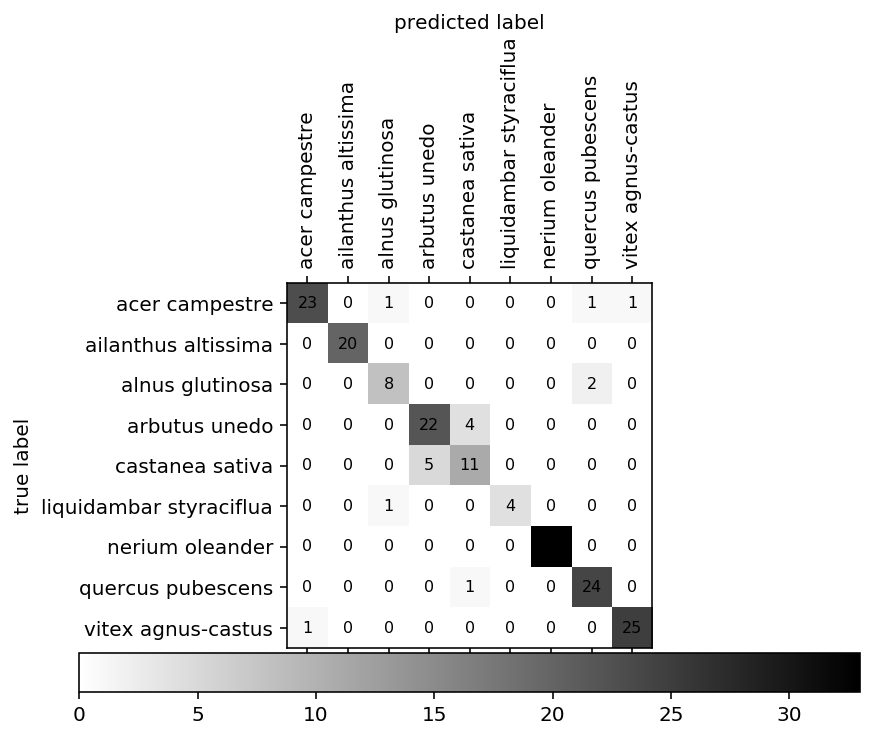

In [27]:
clf = MLPClassifier(activation='tanh', solver='lbfgs', alpha=1e-4, hidden_layer_sizes=accuracies[0][1], random_state = 1)
clf.fit(X_train, y_train[:,0])

y_pred = clf.predict(X_test)
mlp_report = skmetrics.classification_report(y_test, y_pred,
                                         labels=np.arange(len(lencoder.classes_)),
                                         target_names=lencoder.classes_)
confmat_mlp = confusion_matrix(y_test, y_pred)

pl.figure(figsize=(10, 4))
plot_confusion_matrix(confmat_mlp, lencoder.classes_, cmap=cm.gray_r)

print(mlp_report)

# REPORT STUFF

## Code

In [28]:
# The classes we will work with
print(np.unique(meta['classid']))

['acer campestre' 'ailanthus altissima' 'alnus glutinosa' 'arbutus unedo'
 'castanea sativa' 'liquidambar styraciflua' 'nerium oleander'
 'quercus pubescens' 'vitex agnus-castus']


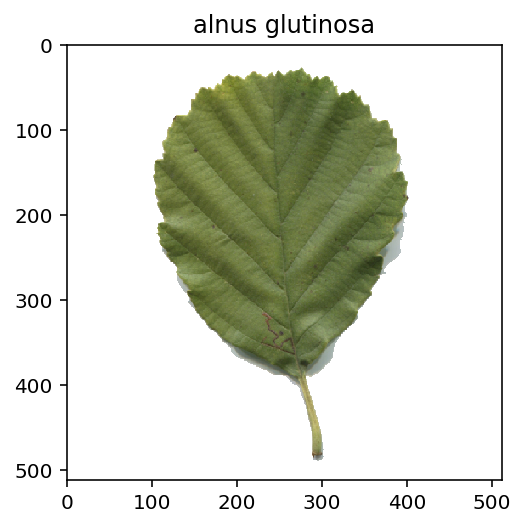

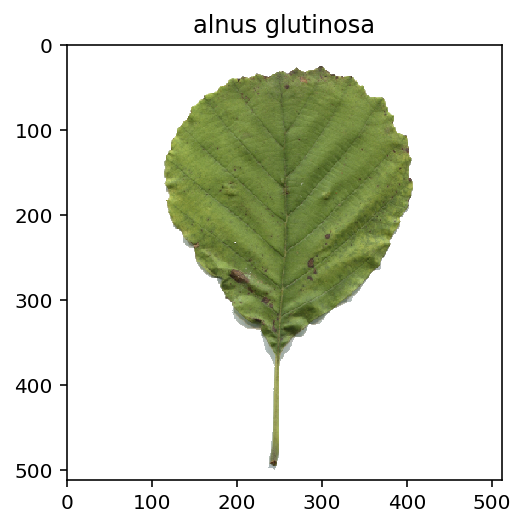

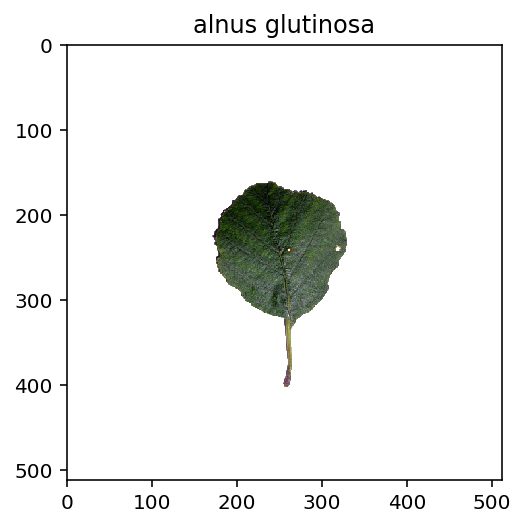

In [29]:
# You can plot some examples images for a given species
import random
examples = np.flatnonzero(meta['classid'] == 'alnus glutinosa')

for idx in random.sample(list(examples), 3):
    pl.figure()
    img = load_img(meta.iloc[idx]['basename'])
    pl.title(meta.iloc[idx]['classid'])
    pl.imshow(img.filled(1))

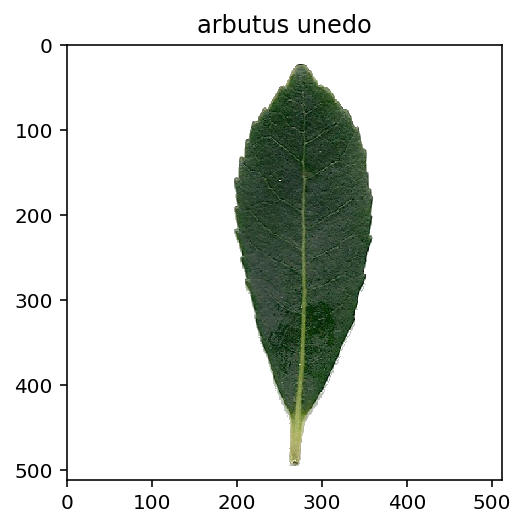

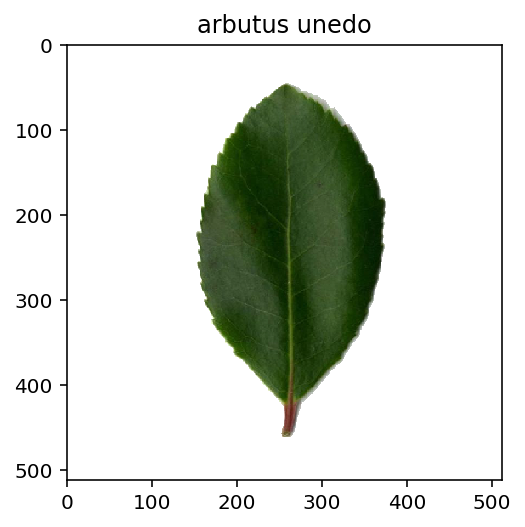

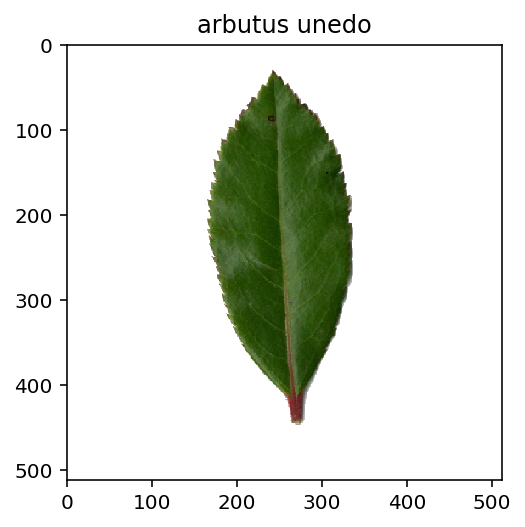

In [30]:
# You can plot some examples images for a given species
import random
examples = np.flatnonzero(meta['classid'] == 'arbutus unedo')

for idx in random.sample(list(examples), 3):
    pl.figure()
    img = load_img(meta.iloc[idx]['basename'])
    pl.title(meta.iloc[idx]['classid'])
    pl.imshow(img.filled(1))

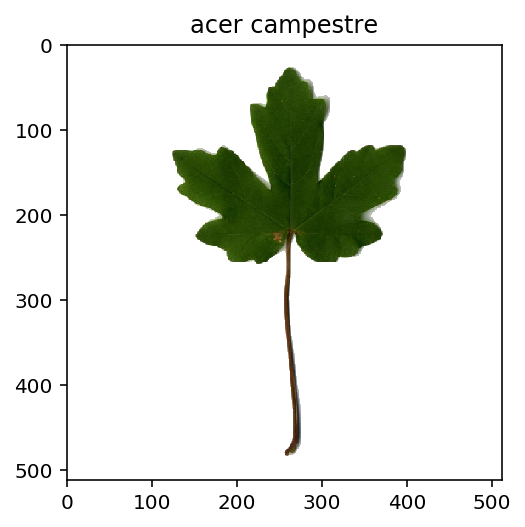

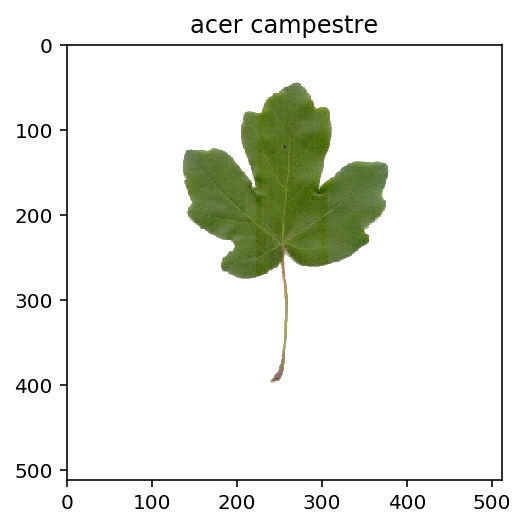

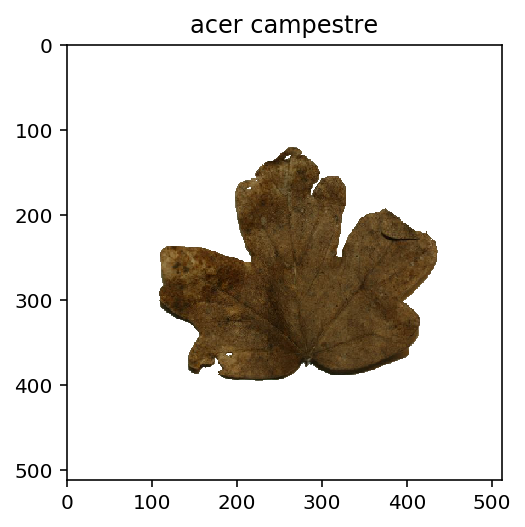

In [31]:
# You can plot some examples images for a given species
import random
examples = np.flatnonzero(meta['classid'] == 'acer campestre')

for idx in random.sample(list(examples), 3):
    pl.figure()
    img = load_img(meta.iloc[idx]['basename'])
    pl.title(meta.iloc[idx]['classid'])
    pl.imshow(img.filled(1))

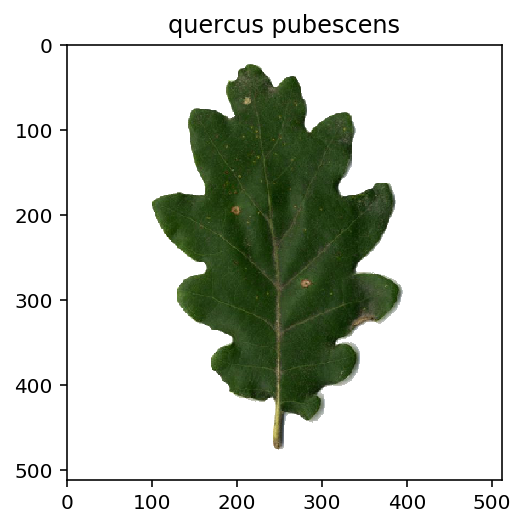

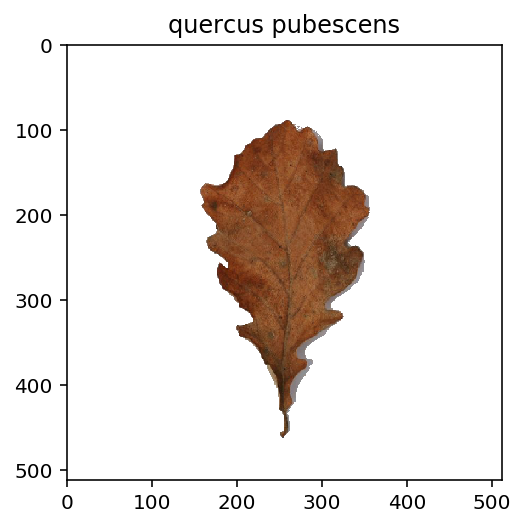

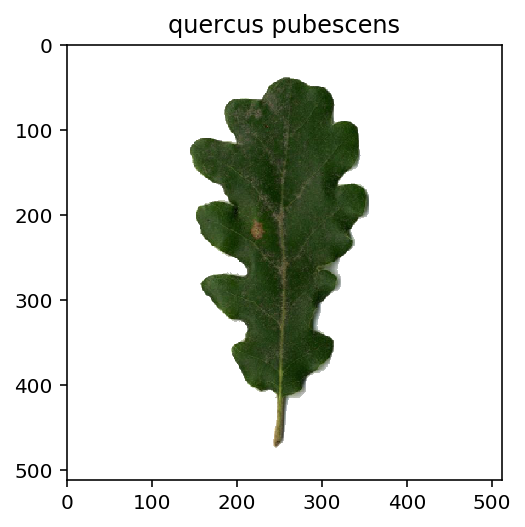

In [32]:
# You can plot some examples images for a given species
import random
examples = np.flatnonzero(meta['classid'] == 'quercus pubescens')

for idx in random.sample(list(examples), 3):
    pl.figure()
    img = load_img(meta.iloc[idx]['basename'])
    pl.title(meta.iloc[idx]['classid'])
    pl.imshow(img.filled(1))

# Report

## Expected TODO

- the report must be **AT MOST** 4 pages
- it should contain answer to the questions asked in this notebook
- it should contain an explanation of the feature you implemented with an overview of how it works (e.g., show some examples) and why you think it is useful
- include your results (either as classification report or confusion matrix) for the kNN classifier
- include the parameters you chose for the knn (value of k) and why you chose it.
- include an analysis of your results

Also include a copy of your scripts (.ipynb or .py) that you used WITHOUT the data. The grading will **ONLY be based on the report** and if we have to look at your scripts to understand what you did, it's a bad sign.

############################

## Explain the implemented features and how it's useful
### curvature_hist
### hull_concave_ratio
This feature differentiates leaves based on how concave they are. A perfectly round leaf with no concave elements will have a convex hull pretty much identical to its contour. A leaf with lots of stems branching out and leaving empty space between them will have long contour but the hull will englobe it all. By checking the ratio between the hull area and the contour area, we get an idea of how concave a leaf is.
Here is an example of a convex leaf:

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


1.0622842279498699

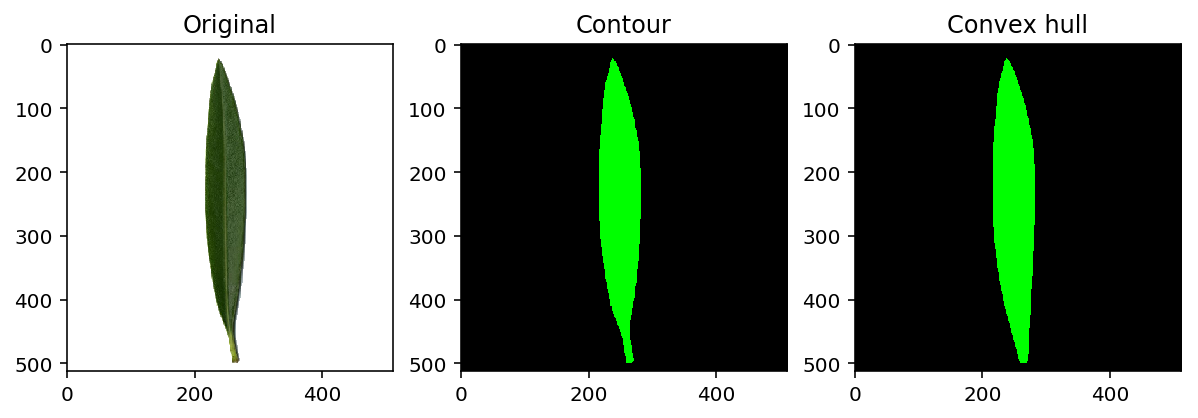

In [33]:
idx = 2
img = load_img(meta.iloc[idx]['basename'])
hull_concave_ratio(img, True)

This leaf has a contour pretty much equal to its convex hull. However, a concave leaf shows a larger difference:

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


1.8837423171834526

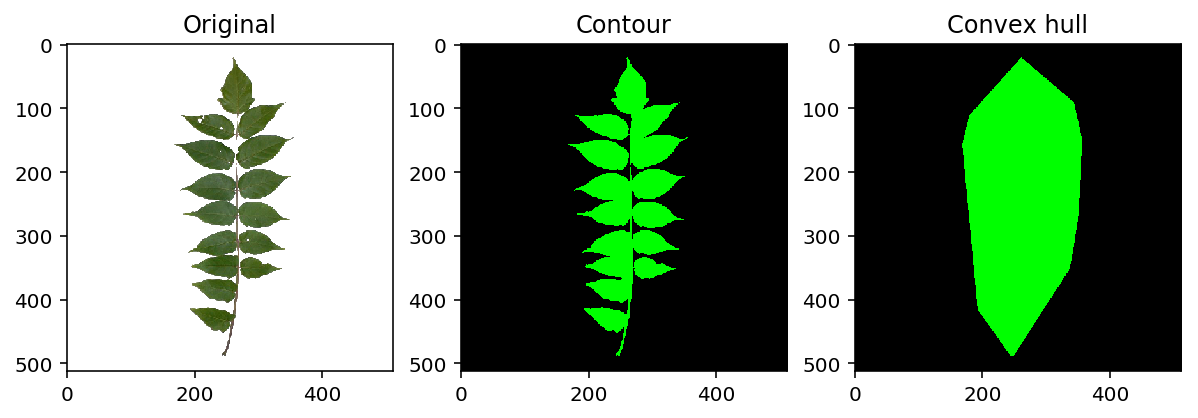

In [34]:
idx = 13
img = load_img(meta.iloc[idx]['basename'])
hull_concave_ratio(img, True)

We can see that the contour is very intricate, and quite different from the hull.

## kNN Results (classification report and confusion matrix)

## Explain the kNN parameters why chose those

## MLP Results
The MLP performed very well on average, with weighted precision and recall averages of 0.88 and 0.87 respectively. The confusion matrix gives us a clear view of the correct classifications, the main diagonal.

                         precision    recall  f1-score   support

         acer campestre       0.96      0.88      0.92        26
    ailanthus altissima       1.00      1.00      1.00        20
        alnus glutinosa       0.80      0.80      0.80        10
          arbutus unedo       0.81      0.85      0.83        26
        castanea sativa       0.69      0.69      0.69        16
liquidambar styraciflua       1.00      0.80      0.89         5
        nerium oleander       1.00      1.00      1.00        33
      quercus pubescens       0.89      0.96      0.92        25
     vitex agnus-castus       0.96      0.96      0.96        26

              micro avg       0.91      0.91      0.91       187
              macro avg       0.90      0.88      0.89       187
           weighted avg       0.91      0.91      0.91       187



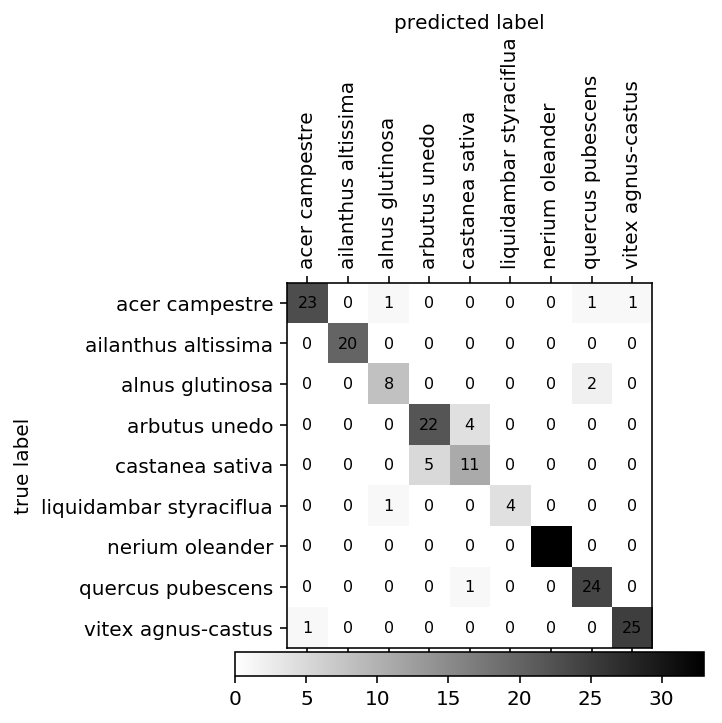

In [35]:
plot_confusion_matrix(confmat_mlp, lencoder.classes_, cmap=cm.gray_r)
print(mlp_report)

 The plants with the most false classifications were 'quercus pubescens' and 'alnus glutinosa'. For the 'alnus glutinosa', the small number of samples in the test set mean that any error will have a big impact on the class accuracy. For 'quercus pubescens', we can observe which leaves are commonly falsly classified as each other:

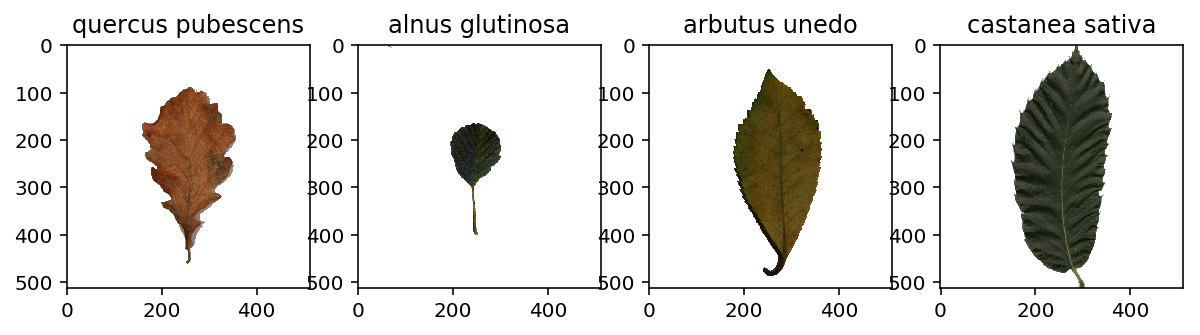

In [36]:
%matplotlib inline
pl.figure(figsize=(10, 4))
for i in range (0, len(meta)):
    if(meta.iloc[i]['classid'] == 'quercus pubescens'):
        pl.subplot(1, 4, 1)
        pl.title(meta.iloc[i]['classid'])
        img = load_img(meta.iloc[i]['basename'])
        pl.imshow(img.filled(1))
        break
for i in range (0, len(meta)):
    if(meta.iloc[i]['classid'] == 'alnus glutinosa'):
        pl.subplot(1, 4, 2)
        pl.title(meta.iloc[i]['classid'])
        img = load_img(meta.iloc[i]['basename'])
        pl.imshow(img.filled(1))
        break
for i in range (0, len(meta)):
    if(meta.iloc[i]['classid'] == 'arbutus unedo'):
        pl.subplot(1, 4, 3)
        pl.title(meta.iloc[i]['classid'])
        img = load_img(meta.iloc[i]['basename'])
        pl.imshow(img.filled(1))
        break
for i in range (0, len(meta)):
    if(meta.iloc[i]['classid'] == 'castanea sativa'):
        pl.subplot(1, 4, 4)
        pl.title(meta.iloc[i]['classid'])
        img = load_img(meta.iloc[i]['basename'])
        pl.imshow(img.filled(1))
        break

All these leaves seem to have a similar edge, meaning the curvature histogram will be close. Since the edges are similar, the hull ratio will be similar as well.
To better classify these samples, we could have used a feature to extract colour from the samples since that varies a lot between them.

## Explain the MLP paramters why chose those
While most parameters of our Multi-Layer Perceptron did not give significantly different results (alpha, activation function...), we had to make a choice regarding the size of the hidden layers.
To do this, we decided to test all combination of values for the hidden layers, first a single hidden layer with 1 to 10 nodes, then test two hidden layers with 1 to 10 nodes each. We simply setup a loop and calculated results with each setup, then sorted them by accuracy on the training set with a 70-30 training/test split on our data. We found the highest performing combination to be two hidden layers with 6 nodes each.

While this method would not be suited for very large data sets due to the "brute force" approach, we found it perfectly suited for our data since all 100 combinations can be calculated in under a minute. For much larger datasets, an estimation based on experience would have do be performed and the results might not be as accurate.


## Analysis of the results
While in theroy a MLP is more elegant than a KNN, they both perform similarly on our data and both have value. A KNN is more intuitive and allows us to understand why a certain sample was classified a certain way (we can visualise a sample in a neighbourhood of similar samples) whereas a MLP remains quite mysterious in its workings.
Since both methods give similar and quite good results, we can assume that our features were useful in determining differences and similarities in the data. The classes that were difficult to distinguish were the same for both methods: 'quercus pubescens' and 'alnus glutinosa' had the most false classifications.